In [1]:
import IPython.display
from ppget.source import DataSource

A_DAY = 60 * 24
DAYS_OF_DATA = 30

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)

# Empty, initialized iterator
source.frame.head()

""


In [2]:
from ppget.model import Model

WINDOW = 25
LEARNING_RATE = 0.00075
MODEL_TYPE = "lstm"

model = Model(name="test", model_type=MODEL_TYPE, window=WINDOW)
model.compile(LEARNING_RATE)
model.describe()

2022-06-27 13:05:30.905786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [3]:
BATCH_SIZE = 32

frame = source.__next__()
# window groups a measurements into a vector of size [sequence_length]
window = frame.generate_window(train_test_split=0.9, sequence_length=WINDOW)

# Data is normalized per window [not global!]
X_train, y_train = window.train_data(True)
X_test, y_test = window.test_data(True)

2006-12-16 17:20:00 -> 2007-01-15 17:20:00


In [4]:
%%time

model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE)

IPython.display.clear_output()

CPU times: user 1min 39s, sys: 7.31 s, total: 1min 47s
Wall time: 1min 30s


In [5]:
%%time
predictions = model.predict(X_test)

13/13 [==============================] - 0s 2ms/step
CPU times: user 484 ms, sys: 26.3 ms, total: 511 ms
Wall time: 482 ms


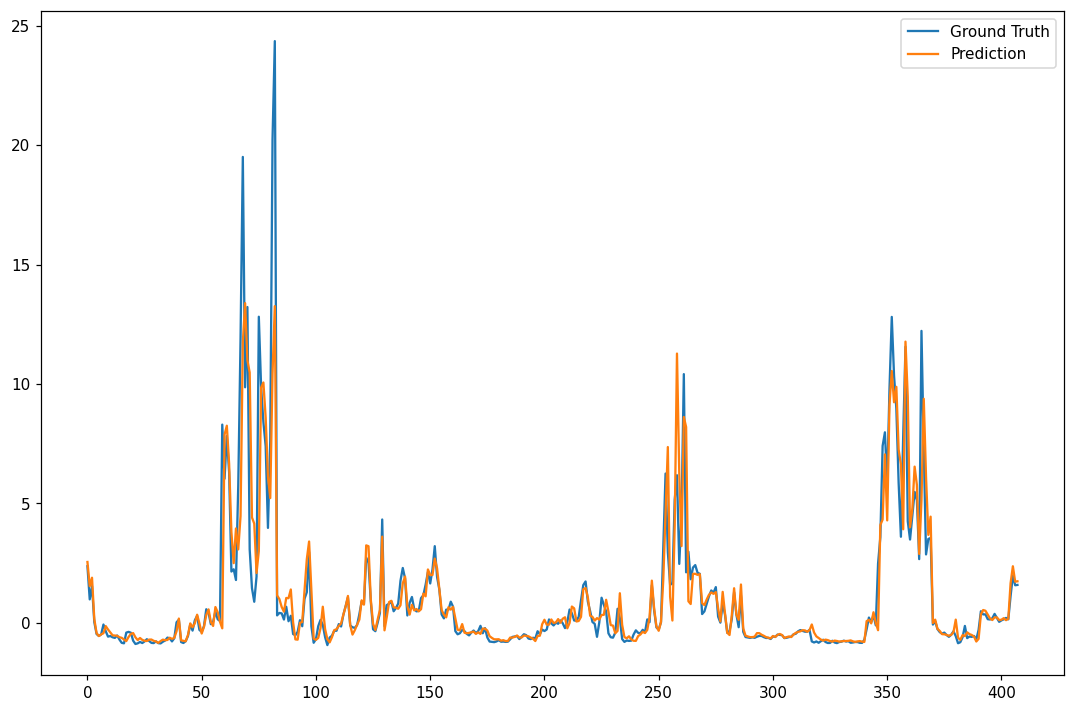

In [8]:
import matplotlib.pyplot as plt

def report_results(expected, predicted, range_limit=None):
    plt.figure(figsize=(12, 8), dpi=110)
    if range_limit:
        plt.xlim(range_limit)
    plt.plot(expected, label='Ground Truth')
    plt.plot(predicted, label='Prediction')
    plt.legend()
    plt.savefig(f"img/model_{MODEL_TYPE}_{WINDOW}_{range_limit}.png")
    plt.show()

report_results(y_test, predictions)

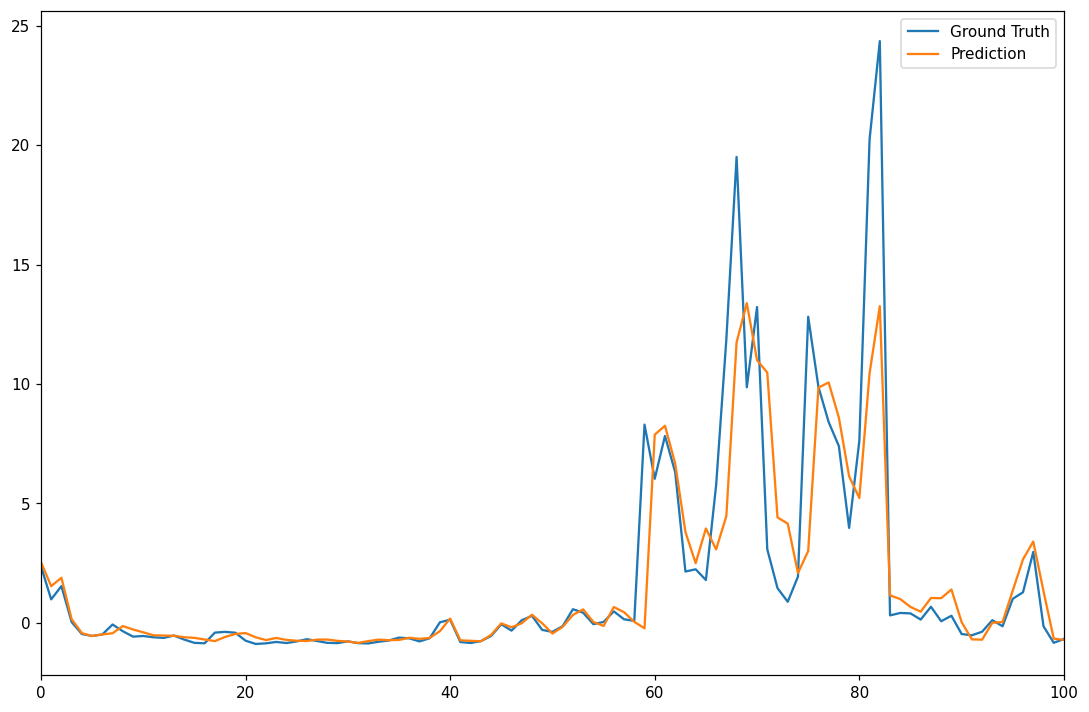

In [11]:
report_results(y_test, predictions, [0, 100])

In [10]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

R2: 0.7619877338325387
